In [19]:
class GCN_PointNet(nn.Module):
    def __init__(self):
        super(GCN_PointNet, self).__init__()
        self.input = nn.Sequential(
            nn.Conv1d(3, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_first = nn.Sequential(
            nn.Conv1d(64, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.mlp_second = nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 200, 1),
            nn.BatchNorm1d(200),
            nn.ReLU()
        )
        self.mlp_third = nn.Sequential(
            nn.Conv1d(200, 128, 1),
            nn.ReLU(),
            nn.Conv1d(128, 2, 1),
            nn.ReLU()
        )
        self.pool1 = SAGPooling(in_channels=64, ratio=0.5)
        self.pool2 = SAGPooling(in_channels=200, ratio=0.2)
        
        
    def forward(self, x, edge_index, edge_attr):
        x = torch.transpose(x, 1, 2)
        #print(x.shape)
        edge_index = edge_index.view(2, -1)
        edge_attr = edge_attr.view(-1)
        x = self.input(x)
        x = self.mlp_first(x)
        
        #print(x.shape)
        x = torch.transpose(x, 1, 2)
        x = x.view(1000, 64)
        temp = self.pool1(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        x = x.view(1, 500, 64)
        x = torch.transpose(x, 1, 2)
        
        #print(x.shape)
        x = self.mlp_second(x)
        
        #print(x.shape)
        x = torch.transpose(x, 1, 2)
        x = x.view(500, 200)
        temp = self.pool2(x, edge_index, edge_attr)
        x, edge_index, edge_attr = temp[0], temp[1], temp[2]
        x = x.view(1, 100, 200)
        x = torch.transpose(x, 1, 2)
        
        #print(x.shape)
        x = F.max_pool1d(x, 100)
        #print(x.shape)
        x = self.mlp_third(x)
        #print(x.shape)
        x = x.squeeze(2)
        #print(x.shape)
        return F.log_softmax(x, dim=1)

In [1]:
import torch
import os
from src import graph_trainer
from src import graph_dataset
from src import graph_model
import json
import pandas as pd
import os
class run():
    def __init__(self, args):
        paths = []
        labels = []
        base = args['base']
        for obj in os.listdir(base):
            temp = base + obj
            if args['data'] == '10':
                if obj in ['sofa', 'airplane', 'vase', 'chair', 'toilet', 'bookshelf', 'bed', 'monitor', 'piano', 'bottle']:
                    for file in os.listdir(temp):
                        paths.append(temp+'/' + file)
                        labels.append(obj)
            else:
                for file in os.listdir(temp):
                        paths.append(temp+'/' + file)
                        labels.append(obj)
        dataset = graph_dataset.GCNdata(paths, labels)
        total = len(dataset)
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [total - int(total * args['val_size']),int(total * args['val_size'])])
        print(total, len(train_dataset), len(test_dataset))
        if args['data'] == '10':
            class_num = 10
        else:
            class_num = 40
        if args['model'] == 'GCN':
            model = graph_model.GCN(pool=args['pool'], ratio=args['ratio'], class_num=class_num)
            opts = {
                    'lr': args['lr'],
                    'epochs': args['epoch'],
                    'batch_size': args['bs']
            }
        self.Train = graph_trainer.trainer(model = model,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)
    def process(self):
        self.Train.train()
        return self.Train.get_stats()

ModuleNotFoundError: No module named 'torch_geometric'

In [1]:
import torch
import os
from src import graph_trainer
from src import graph_dataset
from src import graph_model
import json
import pandas as pd
import os
class run():
    def __init__(self, args):
        paths = []
        labels = []
        base = args['base']
        for obj in os.listdir(base):
            temp = base + obj
            if args['data'] == '10':
                if obj in ['sofa', 'airplane', 'vase', 'chair', 'toilet', 'bookshelf', 'bed', 'monitor', 'piano', 'bottle']:
                    for file in os.listdir(temp):
                        paths.append(temp+'/' + file)
                        labels.append(obj)
            else:
                for file in os.listdir(temp):
                        paths.append(temp+'/' + file)
                        labels.append(obj)
        dataset = graph_dataset.GCNdata(paths, labels)
        total = len(dataset)
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [total - int(total * args['val_size']),int(total * args['val_size'])])
        print(total, len(train_dataset), len(test_dataset))
        if args['data'] == '10':
            class_num = 10
        else:
            class_num = 40
        if args['model'] == 'GCN':
            model = graph_model.GCN(pool=args['pool'], ratio=args['ratio'], class_num=class_num)
            opts = {
                    'lr': args['lr'],
                    'epochs': args['epoch'],
                    'batch_size': args['bs']
            }
        self.Train = graph_trainer.trainer(model = model,
                      train_set = train_dataset,
                      test_set = test_dataset,opts = opts)
    def process(self):
        self.Train.train()
        return self.Train.get_stats()


In [3]:
temp = run({"data": "10", "base": "data/modelnet/modelnet_graph_k15/", "model": "GCN", "pool": "SAG", "ratio": 0.4, "val_size": 0.2, "lr": 0.001, "epoch": 2, "bs": 32})

4862 3890 972
GCN(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 32)
  (conv3): GCNConv(32, 64)
  (pool1): SAGPooling(GraphConv, 32, ratio=0.4, multiplier=1)
  (pool2): SAGPooling(GraphConv, 64, ratio=0.4, multiplier=1)
  (conv4): GCNConv(64, 32)
  (conv5): GCNConv(32, 32)
  (conv6): GCNConv(32, 10)
)
{'lr': 0.001, 'epochs': 2, 'batch_size': 32}


In [5]:
temp.process()

epoch: 1, train loss: 2.199758617345952, test loss: 2.0693298223823184, test accuracy: 0.36213991769547327
epoch: 2, train loss: 1.904977226060284, test loss: 1.8945243517435137, test accuracy: 0.43415637860082307


[(1, 2.199758617345952, 2.0693298223823184, 0.36213991769547327),
 (2, 1.904977226060284, 1.8945243517435137, 0.43415637860082307)]

In [7]:
test = [(1, 2.199758617345952, 2.0693298223823184, 0.36213991769547327),
 (2, 1.904977226060284, 1.8945243517435137, 0.43415637860082307)]
out = pd.DataFrame()
out['epoch'] = [x[0] for x in test]
out['train_ls'] = [x[1] for x in test]
out['test_ls'] = [x[2] for x in test]
out['test_acc'] = [x[3] for x in test]

In [8]:
out

,epoch,train_ls,test_ls,test_acc
0,1,2.199759,2.069330,0.362140
1,2,1.904977,1.894524,0.434156


In [ ]:
    
def main():
    params_base = 'config/model_params/GCN_k_15/10/'
    output_base = 'config/model_results/GCN_k_15/10/'
    for obj in os.listdir(params_base):
        temp_out = output_base + obj[:-5] + '.csv'
        temp_in = params_base + obj
        print(temp_out, temp_in)
        with open(temp_in, 'r') as fp:
            temp_dct = json.load(fp)
        temp = run(temp_dct)
        test = temp.process()
        out = pd.DataFrame()
        out['epoch'] = test[0]
        out['train_ls'] = test[1]
        out['test_ls'] = test[2]
        out['test_acc'] = test[3]
        out.to_csv(temp_out, index=False)

if __name__ == '__main__':
    main()

In [4]:
import json
import pandas as pd
import os
lrs = [1e-3,5e-4]
bss = [32, 64]
ratios = [0.4, 0.6]
pools = ['SAG', 'ASA']
datas = ['10']

i = 0
params_base = 'config/model_params/GCN_k_15/10/GCN_k15_object'

for lr in lrs:
    for bs in bss:
        for ratio in ratios:
            for pool in pools:
                for data in datas:
                    temp = params_base + str(i) + '.json'
                    i += 1
                    sample ={
                        'data': data,
                        'base': 'data/modelnet/modelnet_graph_k15/',
                        'model': 'GCN',
                        'pool': pool,
                        'ratio': ratio,
                        'val_size': 0.2,
                        'lr': lr,
                        'epoch': 30,
                        'bs': bs
                    }
                    with open(temp, 'w') as fp:
                        json.dump(sample, fp)

In [5]:
test ={
    'data': '40',
    'base': 'data/modelnet/modelnet_graph_k15/',
    'model': 'GCN',
    'pool': 'ASA',
    'ratio': 0.3,
    'val_size': 0.2,
    'lr': 1e-3,
    'epoch': 1,
    'bs': 32
}
with open('config/model_params/GCN_k_15/10/GCN_k15_object_test.json', 'w') as fp:
    json.dump(test, fp)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

epoch = [x[0] for x in result]
train_ls = [x[1] for x in result]
test_ls = [x[2] for x in result]
test_acc = [x[3] for x in result]

No handles with labels found to put in legend.


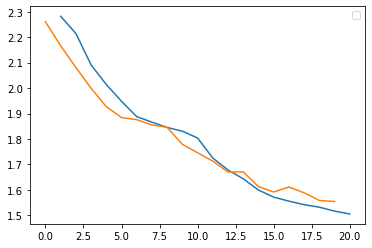

In [31]:
plt.plot(epoch, train_ls, test_ls)

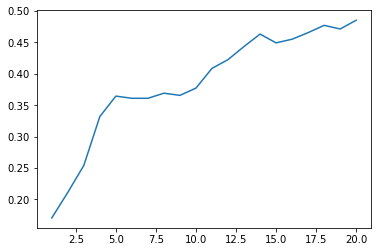

In [32]:
plt.plot(epoch, test_acc)